<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/04_AEGIS_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 🔮 AEGIS Simulations 🧪 🎰

## ⚽ Once we did the scouting using advanced metrics (KPI's) now its time to fine-tunning teams with the new player in roster, here we are gonna get the proyections of performance of Club America with these additions 🕹️

### Antonio Guerrero

In [23]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text
!pip install --quiet xgboost

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch
import random

# Machine Learning

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

In [41]:
# Access to drive and files

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'

# Data needed

df_AEGIS_tunning = pd.read_csv(path + 'AEGIS_tunning_last_season.csv')
df_AEGIS_map = pd.read_csv(path + 'AEGIS_data.csv')
df= pd.read_csv(path + 'Full_Dataset_2021-2025.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df_AEGIS_tunning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155224 entries, 0 to 1155223
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   matchId         1155224 non-null  int64  
 1   playerId        1155224 non-null  float64
 2   period          1155224 non-null  int64  
 3   minute          1155224 non-null  int64  
 4   X               1155224 non-null  float64
 5   Y               1155224 non-null  float64
 6   EventTypeId     1155224 non-null  int64  
 7   IsHomeTeam      1155224 non-null  int64  
 8   IsAccurate      1155224 non-null  int64  
 9   IsGoal          1155224 non-null  int64  
 10  HomeScore       1155224 non-null  float64
 11  AwayScore       1155224 non-null  float64
 12  TimeDelta       1155224 non-null  float64
 13  X_norm          1155224 non-null  float64
 14  Y_norm          1155224 non-null  float64
 15  minute_norm     1155224 non-null  float64
 16  HomeScore_norm  1155224 non-null  fl

In [26]:
id_america = 1229
team_name_prefix = 'club_america'

### 🤼‍♀ Analysis of Substitutions

In [27]:
array_recommendations = [10846,5738,27904]
array_replaced = [30944,35690,29265]

--- Counting Events for Players to be Replaced (Context: Team ID 1229) ---
Player ID 30944: 2545 events
Player ID 35690: 3119 events
Player ID 29265: 3534 events

--- Counting Events for Recommended Players (Context: All Teams) ---
Player ID 10846: 2398 events
Player ID 5738: 2931 events
Player ID 27904: 7107 events

--- Generating Comparison Charts ---
Chart saved: comparison_player_30944_vs_10846.png


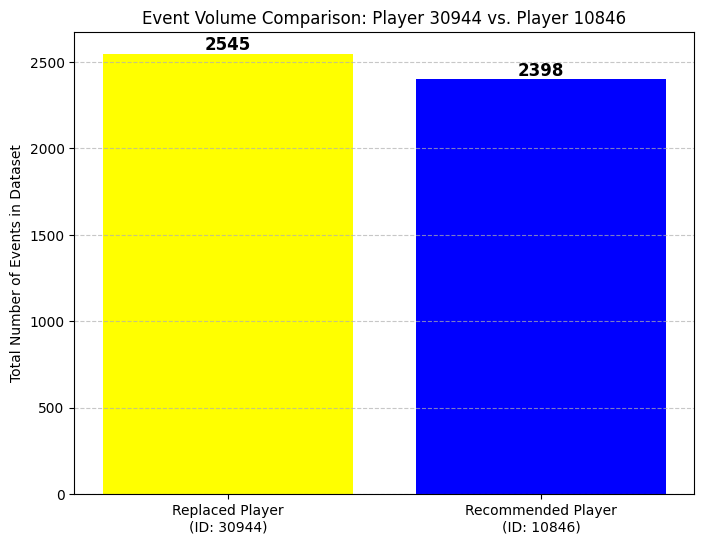

Chart saved: comparison_player_35690_vs_5738.png


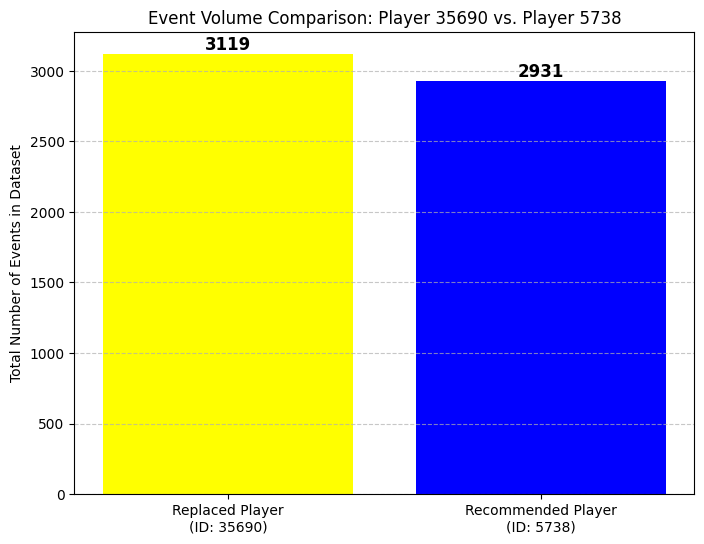

Chart saved: comparison_player_29265_vs_27904.png


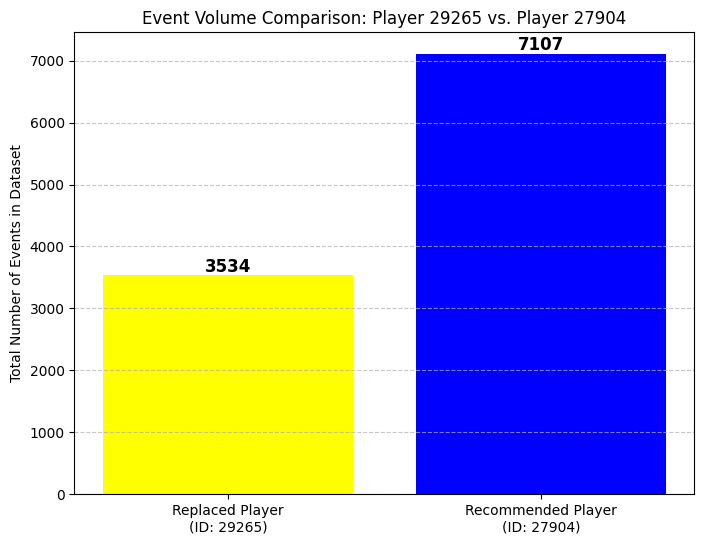

In [28]:
# DATA PREPARATION
df_AEGIS_tunning['team_id'] = np.where(
    df_AEGIS_tunning['IsHomeTeam'] == 1,
    df_AEGIS_tunning['home_team_id'],
    df_AEGIS_tunning['away_team_id']
)


# ANALYSIS: COUNT EVENTS
df_america = df_AEGIS_tunning[df_AEGIS_tunning['team_id'] == id_america]
replaced_player_events = {}
recommended_player_events = {}

print(f"--- Counting Events for Players to be Replaced (Context: Team ID {id_america}) ---")
for player_id in array_replaced:
    count = df_america[df_america['playerId'] == player_id].shape[0]
    replaced_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")

print("\n--- Counting Events for Recommended Players (Context: All Teams) ---")
for player_id in array_recommendations:
    count = df_AEGIS_tunning[df_AEGIS_tunning['playerId'] == player_id].shape[0]
    recommended_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")


# VISUALIZATION: GENERATE AND DISPLAY BAR CHARTS

print("\n--- Generating Comparison Charts ---")
for replaced_id, recommended_id in zip(array_replaced, array_recommendations):
    replaced_count = replaced_player_events.get(replaced_id, 0)
    recommended_count = recommended_player_events.get(recommended_id, 0)

    players_labels = [f'Replaced Player\n(ID: {replaced_id})', f'Recommended Player\n(ID: {recommended_id})']
    event_counts = [replaced_count, recommended_count]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(players_labels, event_counts, color=['#ffff00', '#0000ff'])

    plt.ylabel('Total Number of Events in Dataset')
    plt.title(f'Event Volume Comparison: Player {replaced_id} vs. Player {recommended_id}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=12, fontweight='bold')

    filename = f'comparison_player_{replaced_id}_vs_{recommended_id}.png'
    plt.savefig(filename)
    print(f"Chart saved: {filename}")

    plt.show()

    plt.close()

### Functions and pre-charged models we are gonna use:

In [39]:
# Here we put all the functions for the simulations (most of them from the previous notebooks)

# Lets precharge the function of context to faster compilation of simulations

def create_and_save_full_context_df(df, seq_len=5, output_filename='df_with_context0.pkl'):
    """
    Performs the heavy lifting of creating the sequential context for the entire dataset
    and saves it to a file. This only needs to be run once.
    """
    print(f"--- 🦾 Starting Heavy Pre-processing for all {len(df)} events... ---")
    print("This will take a long time, but you only have to do it once!")

    # Define the features that will form the context
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]

    # We work on a copy to be safe
    data = df.copy()

    # The slow loop to create the "rear-view mirror"
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            print(f"Creating context feature: {new_col_name}...")
            # Group by match and shift to look back in time
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    # Clean up rows at the beginning of matches that don't have a full 5-event history
    data.dropna(subset=[f'c{seq_len}_{context_features[0]}'], inplace=True)

    # Save the processed DataFrame using the efficient pickle format
    print(f"\nSaving the context-rich DataFrame to '{output_filename}'...")
    data.to_pickle(output_filename)

    print(f"✅ Pre-processing complete! Your data is saved and ready for fast training.")
    return data

# Function to create hibrid dfs

def create_hybrid_dataset(base_df, team_id, player_out_id, player_in_id):
    """
    Creates a hybrid dataset for fine-tuning by replacing one player with another.

    Args:
        base_df (pd.DataFrame): The full, original DataFrame with all event data.
        team_id (int): The unique ID of the team to modify.
        player_out_id (int): The ID of the player to remove from the team.
        player_in_id (int): The ID of the player to add to the team.

    Returns:
        pd.DataFrame: A new DataFrame ready for context creation and fine-tuning.
    """
    print(f"--- Creating Hybrid Dataset for Team ID: {team_id} ---")
    print(f"  - Removing Player ID: {player_out_id}")
    print(f"  - Adding Player ID: {player_in_id}\n")

    # Create a 'team_id' column for accurate event ownership
    if 'team_id' not in base_df.columns:
        print("Creating 'team_id' column...")
        base_df['team_id'] = np.where(
            base_df['IsHomeTeam'] == 1,
            base_df['home_team_id'],
            base_df['away_team_id']
        )

    # Isolate all events from the target team
    df_team = base_df[base_df['team_id'] == team_id]
    print(f"Original event count for team {team_id}: {len(df_team)}")

    # Remove all events of the player who is leaving
    df_team_without_player = df_team[df_team['playerId'] != player_out_id]
    print(f"Event count after removing player {player_out_id}: {len(df_team_without_player)}")

    # Get all events of the player who is joining from the entire dataset
    df_player_in = base_df[base_df['playerId'] == player_in_id]
    print(f"Found {len(df_player_in)} events for incoming player {player_in_id}")

    # Concatenate the two DataFrames to create the final hybrid dataset
    df_hybrid = pd.concat([df_team_without_player, df_player_in], ignore_index=True)
    print(f"\n✅ Final hybrid dataset created with {len(df_hybrid)} total events.\n")

    return df_hybrid

# Functions to fine tunning

def prepare_features_and_target(context_df, target_col='EventTypeId', mapping=None):
    """
    Prepares features (X) and target (y) directly from a
    provided context DataFrame. It no longer filters by match_id.
    """
    data = context_df.copy()

    # Prepare y (the target variable)
    y = data[target_col]
    if mapping:
        y = y.map(mapping)

    # Prepare X (the features) by selecting ONLY the context columns ('c1_', 'c2_', etc.)
    context_cols = [col for col in data.columns if col.startswith('c')]
    X = data[context_cols]

    return X, y


def prepare_features_with_prediction(context_df, event_type_model, target_col):
    """
    CORRECTED VERSION: Prepares features from a context_df and adds the
    cascaded prediction from a previously trained model.
    """
    # Use the new, simpler base function
    X, y_target = prepare_features_and_target(context_df, target_col=target_col)

    print(f"Generating EventType predictions for {len(X)} rows...")
    # Ensure feature names match what the model was trained on to avoid errors
    X_for_pred = X[event_type_model.get_booster().feature_names]
    predicted_event_type = event_type_model.predict(X_for_pred)
    X['predicted_EventTypeId'] = predicted_event_type

    return X, y_target

def finetune_classifier_player_replacement(train_df, val_df, base_model_path, new_model_path,
                                           is_goal_model=False, event_type_model=None,
                                           class_mapping=None, num_classes=None):
    """
    CORRECTED Fine-Tuning for Classifiers, designed for player replacement.
    Accepts specific training and validation dataframes.
    """
    print(f"\n--- 🦾 Starting Player Replacement Fine-Tuning for: {new_model_path} ---")

    target_col = 'IsGoal' if is_goal_model else 'IsAccurate' if event_type_model else 'EventTypeId'

    # Prepare data using the corrected functions on the provided dataframes
    # Filtering based on class_mapping is now done BEFORE calling this function.
    if event_type_model:
        X_train, y_train = prepare_features_with_prediction(train_df, event_type_model, target_col)
        X_val, y_val = prepare_features_with_prediction(val_df, event_type_model, target_col)
    else:
        X_train, y_train = prepare_features_and_target(train_df, target_col, class_mapping)
        X_val, y_val = prepare_features_and_target(val_df, target_col, class_mapping)


    # Logic for the specialized goal model
    if is_goal_model:
        train_mask = (train_df['EventTypeId'] == 16)
        X_train, y_train = X_train[train_mask], y_train[train_mask]
        val_mask = (val_df['EventTypeId'] == 16)
        X_val, y_val = X_val[val_mask], y_val[val_mask]

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Initialize the model
    finetuned_model = xgb.XGBClassifier(
        objective='multi:softprob' if num_classes else 'binary:logistic',
        num_class=num_classes if num_classes else None,
        eval_metric='mlogloss' if num_classes else 'logloss',
        learning_rate=0.01, n_estimators=500, early_stopping_rounds=20,
        use_label_encoder=False, random_state=42
    )

    print("Starting fine-tuning...")
    # The base_model is passed to the .fit() method for incremental training
    finetuned_model.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=100,
                        sample_weight=sample_weights,
                        xgb_model=base_model_path # Path to the pre-trained model file
                       )

    finetuned_model.save_model(new_model_path)
    print(f"✅ Fine-tuned model saved to: {new_model_path}")
    return finetuned_model


def finetune_regressor_player_replacement(train_df, val_df, base_model_path, new_model_path, target_col, event_type_model):
    """
    CORRECTED Fine-Tuning for Regressors, designed for player replacement.
    """
    print(f"\n--- 🦾 Starting Player Replacement Fine-Tuning for: {new_model_path} ---")

    # Prepare data using the corrected functions
    X_train, y_train = prepare_features_with_prediction(train_df, event_type_model, target_col)
    X_val, y_val = prepare_features_with_prediction(val_df, event_type_model, target_col)

    if target_col == 'TimeDelta':
        y_train, y_val = np.log1p(y_train), np.log1p(y_val)

    # Initialize the model
    finetuned_model = xgb.XGBRegressor(
        objective='reg:squarederror', eval_metric='rmse', learning_rate=0.01,
        n_estimators=500, early_stopping_rounds=20, random_state=42
    )

    print("Starting fine-tuning...")
    finetuned_model.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=100,
                        xgb_model=base_model_path
                       )

    finetuned_model.save_model(new_model_path)
    print(f"✅ Fine-tuned model saved to: {new_model_path}")
    return finetuned_model

In [30]:
# Here we charge the pre-trained models before and create the ensembled model

# Lets charge all the models

# --- 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS EventTypeModel from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ EventTypeModel loaded successfully!")

# --- 2: Load the Trained Model from the JSON File ---
print("Step 2: Loading the trained AEGIS AccuracyModel from file... 📂")

# Create a new, empty XGBoost model instance
accuracy_model = xgb.XGBClassifier()

model_filename = path + 'accuracy_model1.json'

# Load the trained state into the empty model
accuracy_model.load_model(model_filename)

print("✅ AccuracyModel loaded successfully!")

# --- 3: Load the Trained Model from the JSON File ---

print("Step 3: Loading the trained AEGIS GoalModel from file... 📂")

# Create a new, empty XGBoost model instance
goal_model = xgb.XGBClassifier()

model_filename = path + 'goal_model0.json'

# Load the trained state into the empty model
goal_model.load_model(model_filename)

print("✅ GoalModel loaded successfully!")

# --- 4: Load the Trained Model from the JSON File ---

print("Step 4: Loading the trained AEGIS XModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
x_location = xgb.XGBRegressor()

model_filename = path + 'x_model0.json'

# Load the trained state into the empty model
x_location.load_model(model_filename)

print("✅ XModel loaded successfully!")

# --- 4: Load the Trained Model from the JSON File ---

print("Step 5: Loading the trained AEGIS YModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
y_location = xgb.XGBRegressor()

model_filename = path + 'y_model0.json'

# Load the trained state into the empty model
y_location.load_model(model_filename)

print("✅ YModel loaded successfully!")

# --- 5: Load the Trained Model from the JSON File ---

print("Step 6: Loading the trained AEGIS TimeDeltaModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
timedelta_model = xgb.XGBRegressor()

model_filename = path + 'timedelta_model0.json'

# Load the trained state into the empty model
timedelta_model.load_model(model_filename)

Step 1: Loading the trained AEGIS EventTypeModel from file... 📂
✅ EventTypeModel loaded successfully!
Step 2: Loading the trained AEGIS AccuracyModel from file... 📂
✅ AccuracyModel loaded successfully!
Step 3: Loading the trained AEGIS GoalModel from file... 📂
✅ GoalModel loaded successfully!
Step 4: Loading the trained AEGIS XModel from file... 📂
✅ XModel loaded successfully!
Step 5: Loading the trained AEGIS YModel from file... 📂
✅ YModel loaded successfully!
Step 6: Loading the trained AEGIS TimeDeltaModel from file... 📂


In [44]:
# Mapping

# Get all unique event types from your final, cleaned DataFrame
all_event_types = sorted(df['EventTypeId'].unique())


# Create the class mapping based on the known event types
class_mapping = {original_id: new_id for new_id, original_id in enumerate(all_event_types)}


print("--- Class Mapping Re-created based on known event types ---")
print(f"Total unique event types (classes) based on base model: {len(class_mapping)}")
print("\nThis is your 'translator':")
print(class_mapping)

event_name_map = {
    18: 'Half Start',
    30: 'Pass',
    42: 'Ball Receipt*',
    43: 'Carry',
    17: 'Pressure',
    14: 'Dribble',
    4:  'Duel',
    9:  'Clearance',
    3:  'Dispossessed',
    2:  'Ball Recovery',
    6:  'Block',
    22: 'Foul Committed',
    21: 'Foul Won',
    16: 'Shot',
    23: 'Goal Keeper',
    39: 'Dribbled Past',
    38: 'Miscontrol',
    27: 'Player Off',
    26: 'Player On',
    10: 'Interception',
    33: '50/50',
    34: 'Half End',
    40: 'Injury Stoppage',
    19: 'Substitution',
    36: 'Tactical Shift',
    24: 'Bad Behaviour',
    41: 'Referee Ball-Drop',
    37: 'Error',
    28: 'Shield',
    8:  'Offside',
    25: 'Own Goal For',
    20: 'Own Goal Against' # Added based on the error output
}

num_classes = len(class_mapping) # This will now be 31

--- Class Mapping Re-created based on known event types ---
Total unique event types (classes) based on base model: 32

This is your 'translator':
{np.int64(2): 0, np.int64(3): 1, np.int64(4): 2, np.int64(6): 3, np.int64(8): 4, np.int64(9): 5, np.int64(10): 6, np.int64(14): 7, np.int64(16): 8, np.int64(17): 9, np.int64(18): 10, np.int64(19): 11, np.int64(20): 12, np.int64(21): 13, np.int64(22): 14, np.int64(23): 15, np.int64(24): 16, np.int64(25): 17, np.int64(26): 18, np.int64(27): 19, np.int64(28): 20, np.int64(30): 21, np.int64(33): 22, np.int64(34): 23, np.int64(36): 24, np.int64(37): 25, np.int64(38): 26, np.int64(39): 27, np.int64(40): 28, np.int64(41): 29, np.int64(42): 30, np.int64(43): 31}


## ⚠️ Simulation Player 1:

In [32]:
# We take the first

id_america = 1229

player_enter0 = array_recommendations[0]
player_out0 = array_replaced[0]

print(f"Player entering: {player_enter0}")
print(f"Player leaving: {player_out0}")

# First case out A.Dávila and goes in Murillo Roma

Player entering: 10846
Player leaving: 30944


In [33]:
# We run this just once per player

# Lets make the hybrid df with the two players

data_for_player0 = create_hybrid_dataset(df_AEGIS_tunning, id_america, player_out0, player_enter0)

# Then we create that df with context

data_for_player0 = create_and_save_full_context_df(data_for_player0)

# Save the df in our unit

data_for_player0.to_pickle(path + 'data_for_player0.pkl')

--- Creating Hybrid Dataset for Team ID: 1229 ---
  - Removing Player ID: 30944
  - Adding Player ID: 10846

Original event count for team 1229: 84213
Event count after removing player 30944: 81668
Found 2398 events for incoming player 10846

✅ Final hybrid dataset created with 84066 total events.

--- 🦾 Starting Heavy Pre-processing for all 84066 events... ---
This will take a long time, but you only have to do it once!
Creating context feature: c1_EventTypeId...
Creating context feature: c1_X_norm...
Creating context feature: c1_Y_norm...
Creating context feature: c1_IsHomeTeam...
Creating context feature: c1_IsAccurate...
Creating context feature: c1_IsGoal...
Creating context feature: c1_TimeDelta...
Creating context feature: c1_minute_norm...
Creating context feature: c1_HomeScore_norm...
Creating context feature: c1_AwayScore_norm...
Creating context feature: c2_EventTypeId...
Creating context feature: c2_X_norm...
Creating context feature: c2_Y_norm...
Creating context feature: 

In [34]:
# Lets call the df

df_for_player0 = pd.read_pickle(path + 'data_for_player0.pkl')

In [35]:
# Lets create all stuff for fine tunning

all_match_ids = df_for_player0['matchId'].unique()
train_ids, val_ids = train_test_split(all_match_ids, test_size=0.2, random_state=42)

train_df = df_for_player0[df_for_player0['matchId'].isin(train_ids)]
val_df = df_for_player0[df_for_player0['matchId'].isin(val_ids)]

all_possible_classes = list(class_mapping.values())

df['EventTypeId_mapped'] = df['EventTypeId_mapped'].astype(pd.CategoricalDtype(categories=all_possible_classes))

print(f"Split complete: {len(train_df)} training rows, {len(val_df)} validation rows.")

Split complete: 62985 training rows, 20711 validation rows.


In [45]:
# Lets call the first model

finetuned_event_type_model_player0 = finetune_classifier_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path,
    new_model_path=path,
    is_goal_model=False,
    event_type_model=None,
    class_mapping=class_mapping,
    num_classes=num_classes
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/ ---
Unique EventTypeIds in train_df after filtering: [np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(30), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43)]
Unique EventTypeIds in val_df after filtering: [np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(30), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30], got [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]